In [1]:
# placing import statements here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import zipfile
import urllib.request
import os
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
#Load dataset
# URL of UCI dataset
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip"
zip_path = "Facebook_metrics.zip"

# Download if not already present
if not os.path.exists(zip_path):
    urllib.request.urlretrieve(url, zip_path)

# Extract the CSV
with zipfile.ZipFile(zip_path, 'r') as z:
    csv_name = [f for f in z.namelist() if f.endswith('.csv')][0]
    z.extract(csv_name)

# Load CSV
df = pd.read_csv(csv_name, sep=';')
print("Shape:", df.shape)
df.head()



Shape: (500, 19)


,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393



Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Page total likes                                                     500 non-null    int64  
 1   Type                                                                 500 non-null    object 
 2   Category                                                             500 non-null    int64  
 3   Post Month                                                           500 non-null    int64  
 4   Post Weekday                                                         500 non-null    int64  
 5   Post Hour                                                            500 non-null    int64  
 6   Paid                                                                 499 

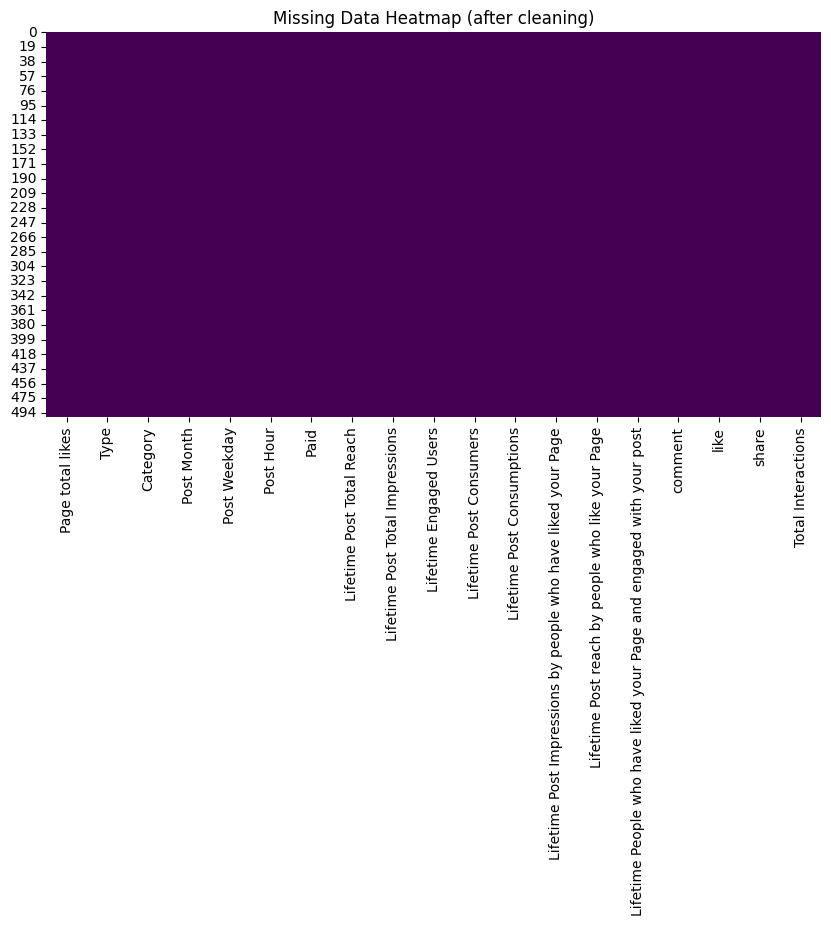

In [3]:
print("\nData types and non-null counts:")
print(df.info())

# Missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Duplicate rows
print("\nDuplicate rows:", df.duplicated().sum())

# Negative value check
numeric_cols = df.select_dtypes(include=[np.number]).columns
negatives = {col: (df[col] < 0).sum() for col in numeric_cols if (df[col] < 0).any()}
print("\nColumns with negative values:", negatives)

# Fill missing values
df.fillna({
    'Paid': df['Paid'].mode()[0],   # Paid is binary-like
    'like': df['like'].median(),    # Median handles skew
    'share': df['share'].median()
}, inplace=True)

# Verify missing values handled
print("\nMissing values after adjustments:")
print(df.isnull().sum())

plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap (after cleaning)")
plt.show()


Feature matrix shape: (500, 18)
Target shape: (500,)
Page total likes: p=0.0000 -> Not normal
Category: p=0.0000 -> Not normal
Post Month: p=0.0000 -> Not normal
Post Weekday: p=0.0000 -> Not normal
Post Hour: p=0.0000 -> Not normal
Paid: p=0.0000 -> Not normal
Lifetime Post Total Reach: p=0.0000 -> Not normal
Lifetime Post Total Impressions: p=0.0000 -> Not normal
Lifetime Engaged Users: p=0.0000 -> Not normal
Lifetime Post Consumers: p=0.0000 -> Not normal
Lifetime Post Consumptions: p=0.0000 -> Not normal
Lifetime Post Impressions by people who have liked your Page: p=0.0000 -> Not normal
Lifetime Post reach by people who like your Page: p=0.0000 -> Not normal
Lifetime People who have liked your Page and engaged with your post: p=0.0000 -> Not normal
comment: p=0.0000 -> Not normal
like: p=0.0000 -> Not normal
share: p=0.0000 -> Not normal


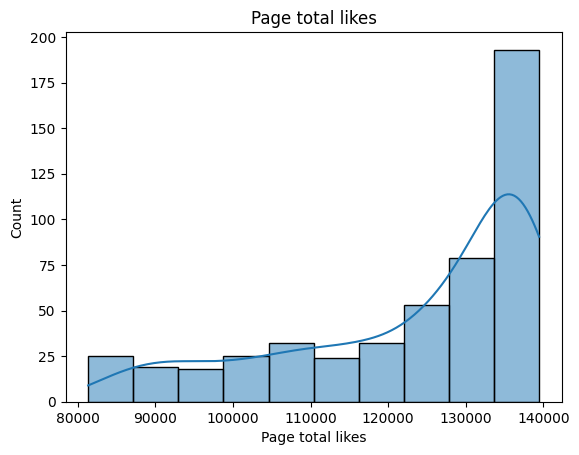

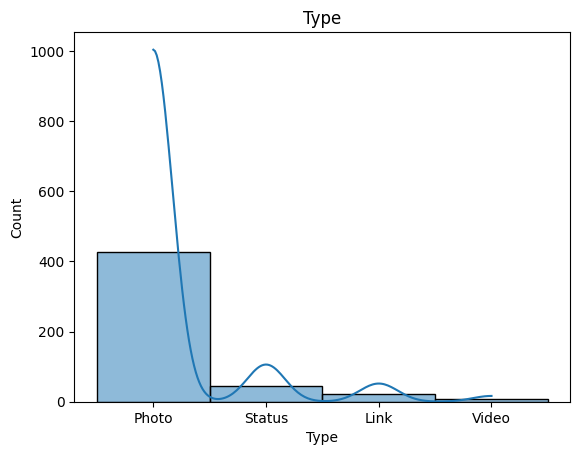

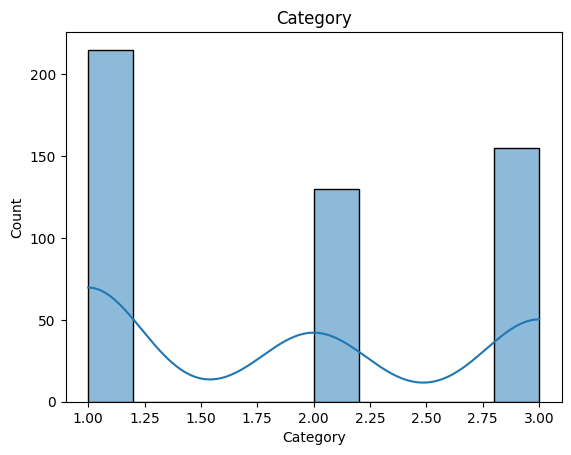

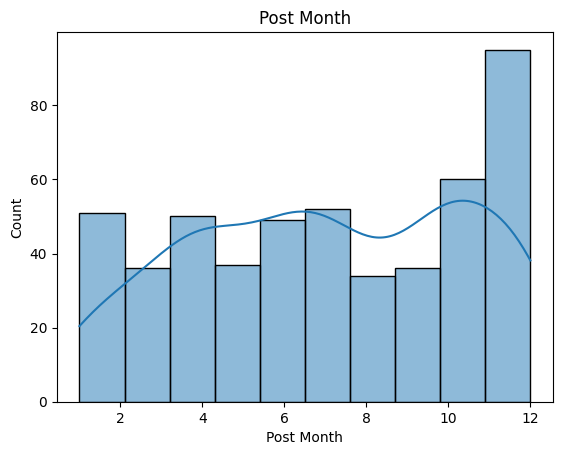

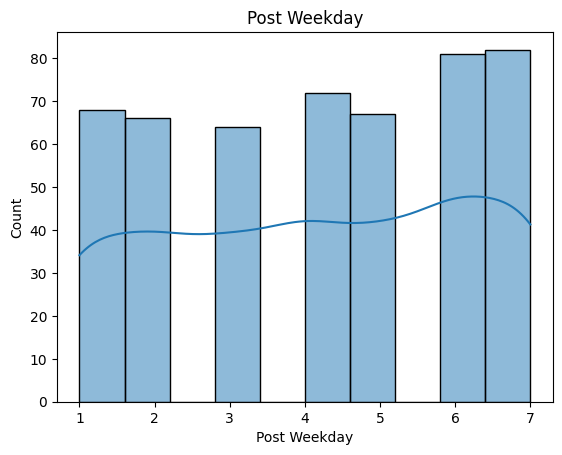

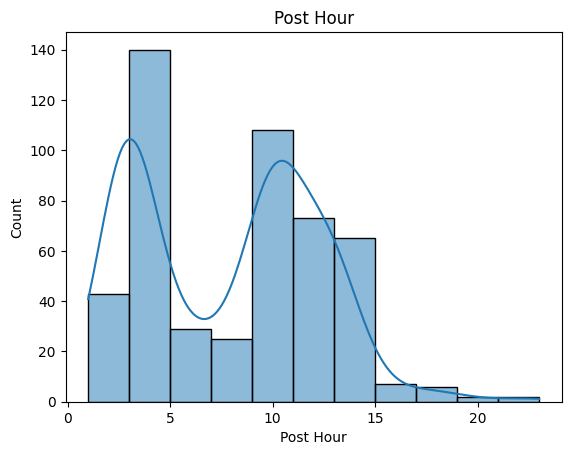

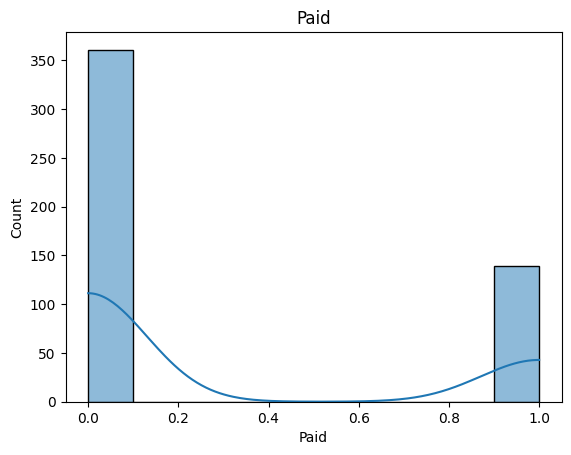

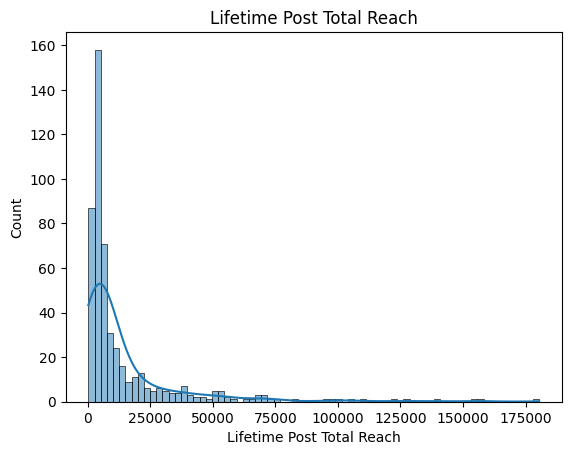

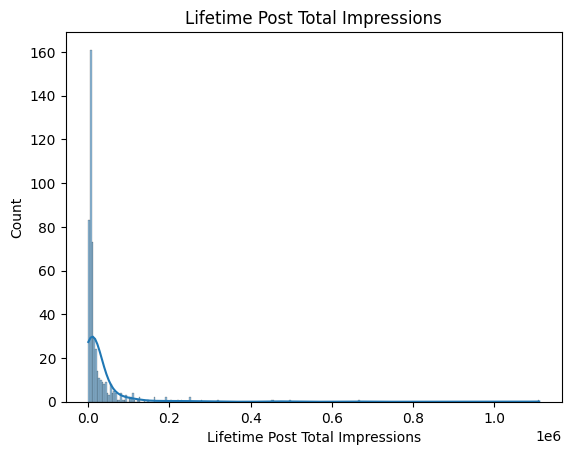

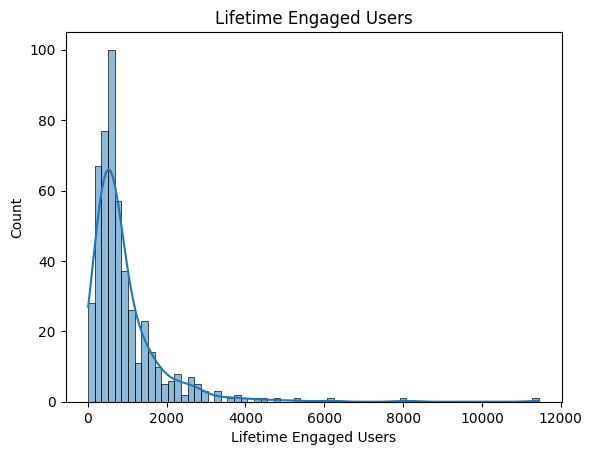

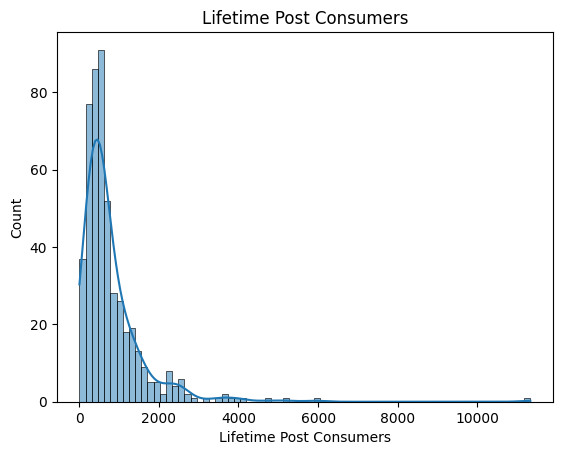

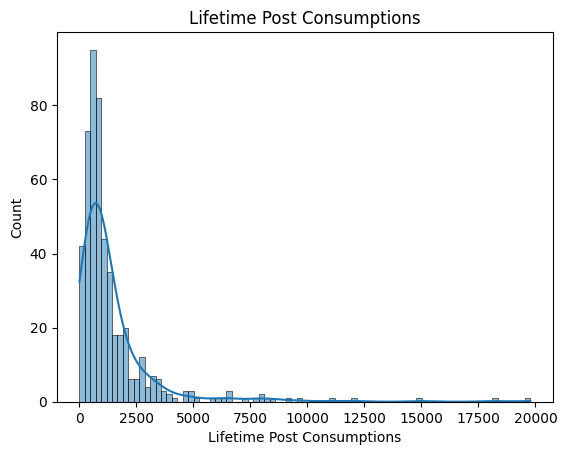

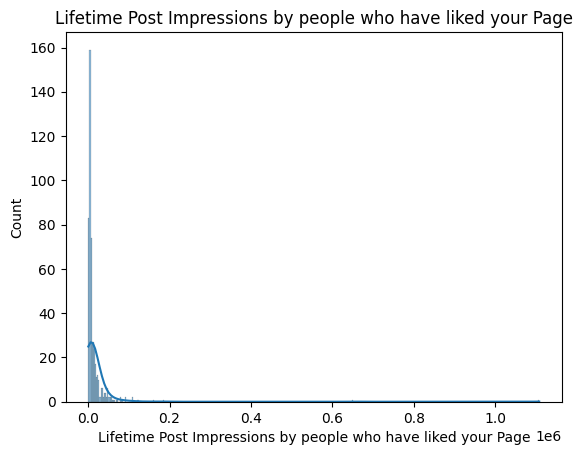

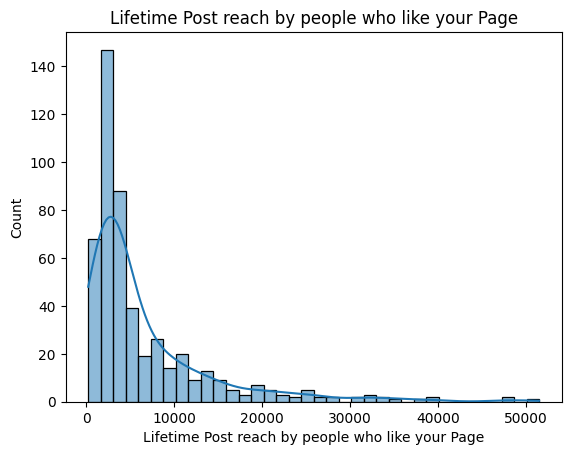

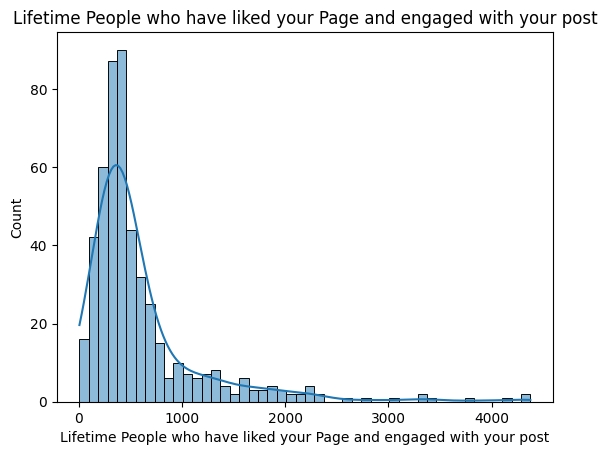

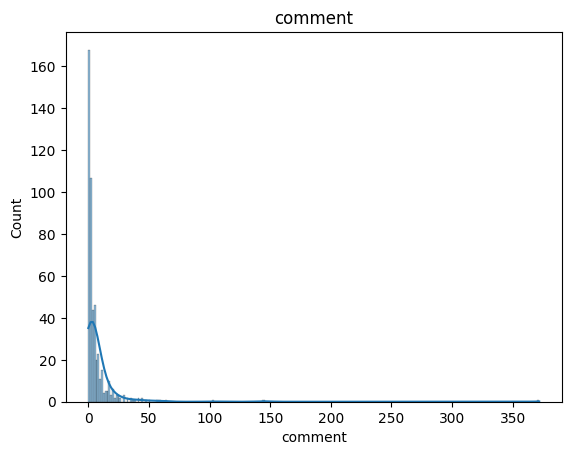

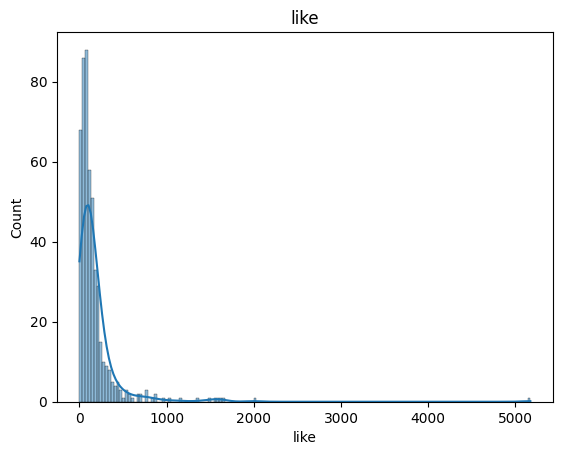

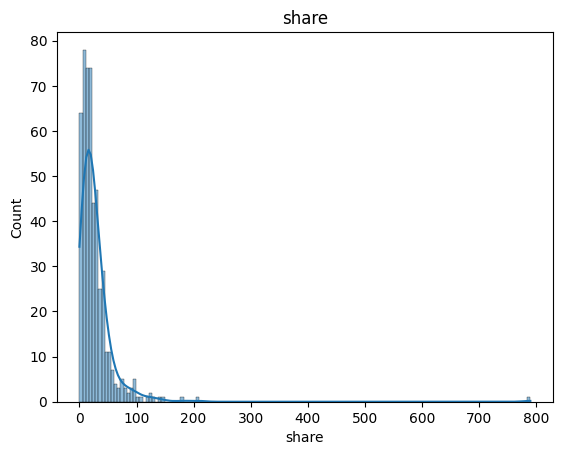

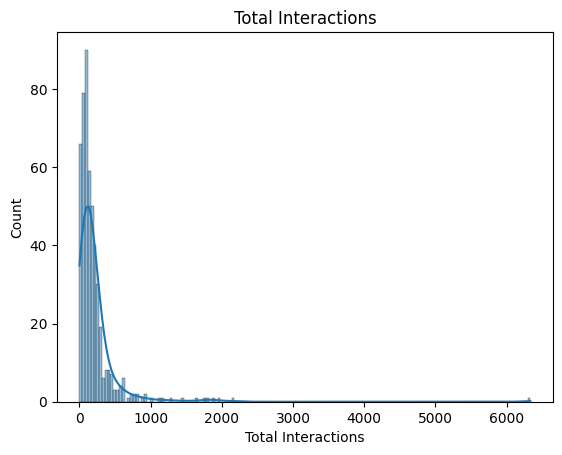

In [4]:
# exploratory data analysis

# Features and target
X = df.drop(columns=['Total Interactions'])
y = df['Total Interactions']

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)


# Convert 'Type' to dummy variables
X = pd.get_dummies(X, columns=['Type'], drop_first=True)

for col in X.select_dtypes(include=[np.number]).columns:
    stat, p = stats.shapiro(X[col].sample(min(500, len(X[col]))))  # Shapiro test
    print(f"{col}: p={p:.4f} -> {'Normal' if p > 0.05 else 'Not normal'}")

for col in df.columns:
    sns.histplot(df[col], kde=True)
    plt.title(col)
    plt.show()



All attributes are non-normal - applying robust scaling...
Numeric features to scale: 17
Categorical features (already encoded): 3

2. Analyzing correlations...
Top 10 features most correlated with Total Interactions:
like                                                                   0.997603
share                                                                  0.928164
comment                                                                0.864944
Lifetime Post reach by people who like your Page                       0.617929
Lifetime Engaged Users                                                 0.572159
Lifetime Post Total Reach                                              0.538597
Lifetime People who have liked your Page and engaged with your post    0.492570
Lifetime Post Consumers                                                0.354502
Lifetime Post Total Impressions                                        0.343358
Lifetime Post Impressions by people who have liked your Page  

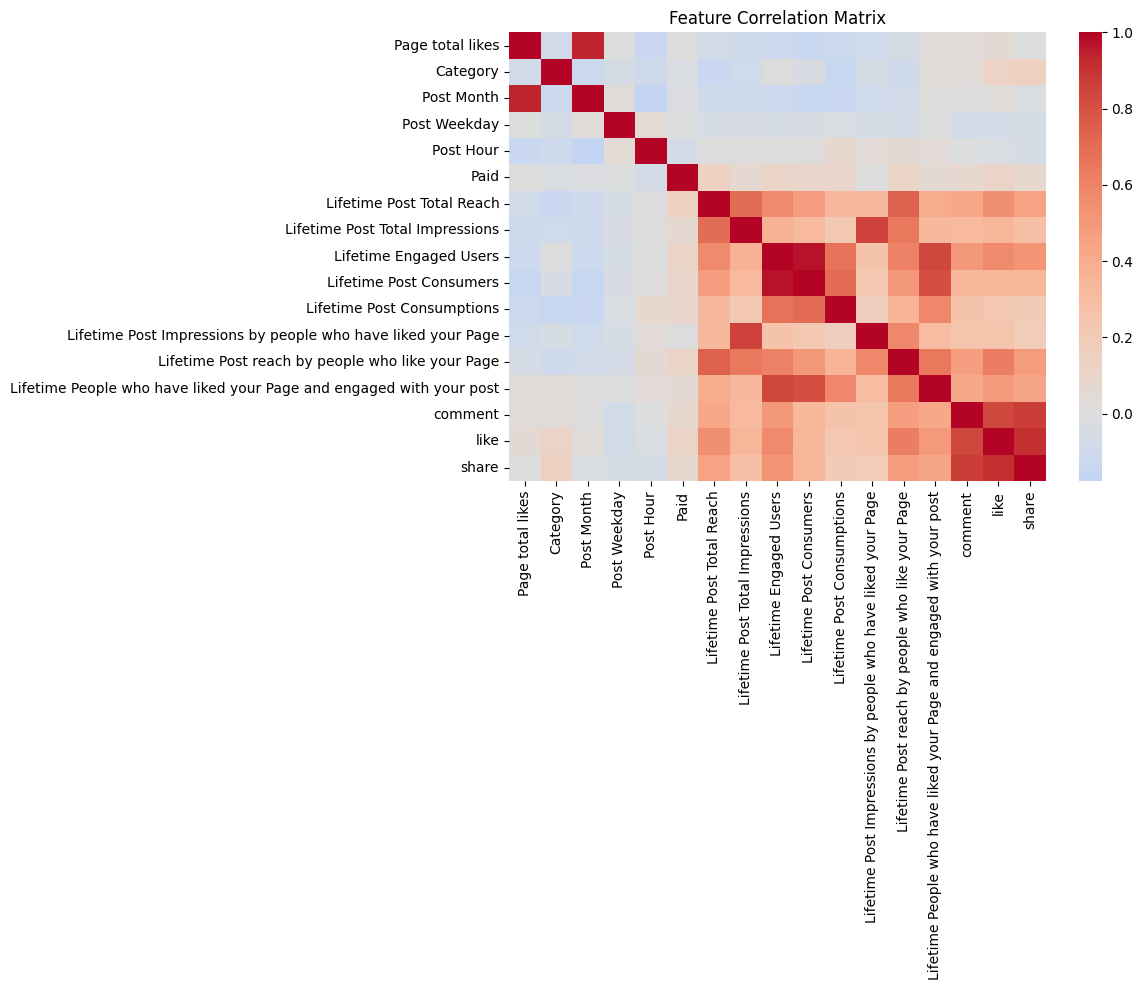


Highly correlated pairs (|r| > 0.8): 8
  Page total likes ↔ Post Month: 0.941
  Lifetime Post Total Impressions ↔ Lifetime Post Impressions by people who have liked your Page: 0.851
  Lifetime Engaged Users ↔ Lifetime Post Consumers: 0.968
  Lifetime Engaged Users ↔ Lifetime People who have liked your Page and engaged with your post: 0.839
  Lifetime Post Consumers ↔ Lifetime People who have liked your Page and engaged with your post: 0.814

3. Selecting important features...
Selected top 9 features:
   1. Lifetime Post Total Reach                Score:   203.49
   2. Lifetime Post Total Impressions          Score:    66.56
   3. Lifetime Engaged Users                   Score:   242.37
   4. Lifetime Post Consumers                  Score:    71.58
   5. Lifetime Post reach by people who like y Score:   307.61
   6. Lifetime People who have liked your Page Score:   159.53
   7. comment                                  Score:  1479.19
   8. like                                     Score

In [5]:

# 1. STANDARDIZE/NORMALIZE THE DATA
print("All attributes are non-normal - applying robust scaling...")

# RobustScaler since it handles outliers and skewed data better than StandardScaler

# Separate numeric features for scaling
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [col for col in X.columns if col not in numeric_features]

print(f"Numeric features to scale: {len(numeric_features)}")
print(f"Categorical features (already encoded): {len(categorical_features)}")

# Apply RobustScaler
scaler = RobustScaler()
X_scaled = X.copy()
X_scaled[numeric_features] = scaler.fit_transform(X[numeric_features])


# 2. CORRELATION ANALYSIS
print("\n2. Analyzing correlations...")

# Correlation with target variable
target_correlations = X_scaled[numeric_features].corrwith(y).sort_values(key=abs, ascending=False)
print("Top 10 features most correlated with Total Interactions:")
print(target_correlations.head(10))

# Feature correlation matrix
correlation_matrix = X_scaled[numeric_features].corr()

# Visualize correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Check for multicollinearity (highly correlated features)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

print(f"\nHighly correlated pairs (|r| > 0.8): {len(high_corr_pairs)}")
for pair in high_corr_pairs[:5]:  # Show first 5
    print(f"  {pair[0]} ↔ {pair[1]}: {pair[2]:.3f}")

# 3. FEATURE SELECTION
print("\n3. Selecting important features...")


# Select top K features
k_best = 9
selector = SelectKBest(score_func=f_regression, k=k_best)
X_selected = selector.fit_transform(X_scaled[numeric_features], y)

# Get selected feature names
selected_features = selector.get_feature_names_out(numeric_features)
feature_scores = selector.scores_[selector.get_support()]

print(f"Selected top {k_best} features:")
for i, (feature, score) in enumerate(zip(selected_features, feature_scores), 1):
    print(f"  {i:2d}. {feature[:40]:40s} Score: {score:8.2f}")

# Create final feature matrix with selected features + categorical features
final_features = list(selected_features) + categorical_features
X_final = X_scaled[final_features]

print(f"\nFinal feature set: {X_final.shape[1]} features")
print(f"  - Selected numeric: {len(selected_features)}")
print(f"  - Categorical: {len(categorical_features)}")

# 4. TRAIN-TEST SPLIT
print("\n4. Splitting data...")

# Split the data (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=None
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

# 5. SUMMARY
print(f"\n{'='*50}")
print("PREPROCESSING SUMMARY")
print(f"{'='*50}")
print(f"✓ Missing data handled")
print(f"✓ Non-normal distributions identified")
print(f"✓ Robust scaling applied")
print(f"✓ Feature selection completed ({k_best} features)")
print(f"✓ Data split into train/test sets")

# Show summary of preprocessing transformations
print(f"\nData transformation summary:")
print(f"Original shape: {X.shape}")
print(f"After preprocessing: {X_final.shape}")
print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

In [6]:
# modeling here
# First, standardize the data as recommended
print("Standardizing data for SGDRegressor...")
scaler_sgd = StandardScaler()
X_train_scaled = scaler_sgd.fit_transform(X_train)
X_test_scaled = scaler_sgd.transform(X_test)
print("✓ Data standardized using StandardScaler")

# Define hyperparameters to test
print("\nTesting different hyperparameter combinations...")

# Hyperparameter combinations to test
hyperparameter_combinations = [
    # (learning_rate, max_iter, loss, penalty, alpha)
    ('constant', 1000, 'squared_error', 'l2', 0.0001),
    ('constant', 2000, 'squared_error', 'l2', 0.001),
    ('invscaling', 1000, 'squared_error', 'l1', 0.0001),
    ('invscaling', 2000, 'squared_error', 'l1', 0.001),
    ('adaptive', 1500, 'squared_error', 'l2', 0.0001),
    ('adaptive', 2000, 'squared_error', 'elasticnet', 0.001),
    ('constant', 3000, 'squared_error', 'l2', 0.01),
    ('invscaling', 1500, 'squared_error', 'elasticnet', 0.0001),
]

# Store results for comparison
sgd_results = []

print(f"{'Config':<6} {'LR':<12} {'MaxIter':<8} {'Loss':<15} {'Penalty':<12} {'Alpha':<8} {'Train R²':<10} {'Test R²':<10} {'Test RMSE':<12}")
print("-" * 100)

for i, (lr, max_iter, loss, penalty, alpha) in enumerate(hyperparameter_combinations, 1):
    # Create and train SGD model
    sgd_model = SGDRegressor(
        learning_rate=lr,
        max_iter=max_iter,
        loss=loss,
        penalty=penalty,
        alpha=alpha,
        random_state=42,
        eta0=0.01,  # Initial learning rate for constant/invscaling
        tol=1e-4
    )

    # Fit the model
    sgd_model.fit(X_train_scaled, y_train)

    # Make predictions
    y_train_pred = sgd_model.predict(X_train_scaled)
    y_test_pred = sgd_model.predict(X_test_scaled)

    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Store results
    sgd_results.append({
        'config': i,
        'learning_rate': lr,
        'max_iter': max_iter,
        'loss': loss,
        'penalty': penalty,
        'alpha': alpha,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'model': sgd_model
    })

    # Print results
    print(f"{i:<6} {lr:<12} {max_iter:<8} {loss:<15} {penalty:<12} {alpha:<8.4f} {train_r2:<10.4f} {test_r2:<10.4f} {test_rmse:<12.2f}")

# Find best model based on test R²
best_sgd = max(sgd_results, key=lambda x: x['test_r2'])
print(f"\n Best SGD Model Configuration:")
print(f"   Config {best_sgd['config']}: Learning Rate = {best_sgd['learning_rate']}, Max Iter = {best_sgd['max_iter']}")
print(f"   Loss = {best_sgd['loss']}, Penalty = {best_sgd['penalty']}, Alpha = {best_sgd['alpha']}")
print(f"   Test R² = {best_sgd['test_r2']:.4f}, Test RMSE = {best_sgd['test_rmse']:.2f}")

# Detailed metrics for best SGD model
best_sgd_model = best_sgd['model']
y_train_pred_best = best_sgd_model.predict(X_train_scaled)
y_test_pred_best = best_sgd_model.predict(X_test_scaled)

print(f"\n Detailed Metrics for Best SGD Model:")
print(f"   Training Metrics:")
print(f"     R² Score: {r2_score(y_train, y_train_pred_best):.4f}")
print(f"     RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred_best)):.2f}")
print(f"     MAE: {mean_absolute_error(y_train, y_train_pred_best):.2f}")

print(f"   Test Metrics:")
print(f"     R² Score: {r2_score(y_test, y_test_pred_best):.4f}")
print(f"     RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_best)):.2f}")
print(f"     MAE: {mean_absolute_error(y_test, y_test_pred_best):.2f}")

# Check for convergence
if hasattr(best_sgd_model, 'n_iter_'):
    print(f"   Convergence: {best_sgd_model.n_iter_} iterations")

Standardizing data for SGDRegressor...
✓ Data standardized using StandardScaler

Testing different hyperparameter combinations...
Config LR           MaxIter  Loss            Penalty      Alpha    Train R²   Test R²    Test RMSE   
----------------------------------------------------------------------------------------------------
1      constant     1000     squared_error   l2           0.0001   0.9997     0.9997     3.95        
2      constant     2000     squared_error   l2           0.0010   0.9997     0.9997     3.99        
3      invscaling   1000     squared_error   l1           0.0001   0.9998     0.9998     2.91        
4      invscaling   2000     squared_error   l1           0.0010   0.9998     0.9998     2.90        
5      adaptive     1500     squared_error   l2           0.0001   0.9998     0.9998     2.93        
6      adaptive     2000     squared_error   elasticnet   0.0010   0.9998     0.9998     3.13        
7      constant     3000     squared_error   l2        

In [7]:
        print("Preparing data for OLS regression...")
X_train_ols = sm.add_constant(X_train)
X_test_ols = sm.add_constant(X_test)

# Fit OLS model
print("Fitting OLS model...")
ols_model = sm.OLS(y_train, X_train_ols)
ols_results = ols_model.fit()

# Dcomprehensive OLS summary
print("\n OLS MODEL SUMMARY:")
print("="*60)
print(ols_results.summary())

# Additional OLS metrics and interpretations
print(f"\n OLS Model Interpretation:")
print("-" * 40)

# Make predictions for additional metrics
y_train_pred_ols = ols_results.predict(X_train_ols)
y_test_pred_ols = ols_results.predict(X_test_ols)

# Calculate additional metrics
train_r2_ols = r2_score(y_train, y_train_pred_ols)
test_r2_ols = r2_score(y_test, y_test_pred_ols)
test_rmse_ols = np.sqrt(mean_squared_error(y_test, y_test_pred_ols))
test_mae_ols = mean_absolute_error(y_test, y_test_pred_ols)

print(f"Training R²: {train_r2_ols:.4f}")
print(f"Test R²: {test_r2_ols:.4f}")
print(f"Test RMSE: {test_rmse_ols:.2f}")
print(f"Test MAE: {test_mae_ols:.2f}")

# Interpreting key OLS statistics
print(f"\n Key OLS Statistics Interpretation:")
print("-" * 45)
print(f"R-squared: {ols_results.rsquared:.4f}")
print(f"  → {ols_results.rsquared*100:.1f}% of variance in Total Interactions is explained by the model")

print(f"Adjusted R-squared: {ols_results.rsquared_adj:.4f}")
print(f"  → Adjusted for number of predictors ({X_train.shape[1]} features)")

print(f"F-statistic: {ols_results.fvalue:.2f}")
print(f"F-statistic p-value: {ols_results.f_pvalue:.2e}")
if ols_results.f_pvalue < 0.05:
    print(f"  → Model is statistically significant (p < 0.05)")
else:
    print(f"  → Model is not statistically significant (p >= 0.05)")

# Coefficient interpretation
print(f"\n Coefficient Interpretation (Top 5 by absolute value):")
print("-" * 55)
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': ols_results.params[1:],  # Exclude intercept
    'Std Error': ols_results.bse[1:],
    'T-value': ols_results.tvalues[1:],
    'P-value': ols_results.pvalues[1:]
})

# Sort by absolute coefficient value
coef_df_sorted = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

print(f"{'Feature':<35} {'Coefficient':<12} {'Std Error':<12} {'T-value':<10} {'P-value':<12} {'Significant':<12}")
print("-" * 100)

for _, row in coef_df_sorted.head(5).iterrows():
    significant = "Yes" if row['P-value'] < 0.05 else "No"
    feature_name = row['Feature'][:34]  # Truncate long names
    print(f"{feature_name:<35} {row['Coefficient']:<12.4f} {row['Std Error']:<12.4f} {row['T-value']:<10.2f} {row['P-value']:<12.4f} {significant:<12}")

# Model comparison
print(f"\n  MODEL COMPARISON:")
print("-" * 25)
print(f"{'Metric':<20} {'Best SGD':<15} {'OLS':<15}")
print("-" * 50)
print(f"{'Test R²':<20} {best_sgd['test_r2']:<15.4f} {test_r2_ols:<15.4f}")
print(f"{'Test RMSE':<20} {best_sgd['test_rmse']:<15.2f} {test_rmse_ols:<15.2f}")
print(f"{'Test MAE':<20} {best_sgd['test_mae']:<15.2f} {test_mae_ols:<15.2f}")

# Determining better model
if best_sgd['test_r2'] > test_r2_ols:
    print(f"\n Best performing model: SGD Regressor (Higher R²)")
else:
    print(f"\n Best performing model: OLS (Higher R²)")

print(f"\n Model construction completed!")
print(f"   - SGD: Tested {len(hyperparameter_combinations)} configurations")
print(f"   - OLS: Full statistical analysis provided")
print(f"   - Both models ready for diagnostics phase")

Preparing data for OLS regression...
Fitting OLS model...


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
# diagnostics here